In [32]:
# Import modules and subroutines:
include("../subroutines/Subroutines.jl");

3.10.9


In [2]:
using ConfParser
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

md_fname = "h6_sto3g_020524%1552.hdf5"

chemical_data_list = ReadIn("../datasets/pyscf_data/"*md_fname)

conf = ConfParse("../configs/pyscf_configs/h6_octahedron_sto3g.ini")
parse_conf!(conf)
bond_lengths = parse.(Float64, retrieve(conf, "GEOMETRIES", "xyz_files"));

In [3]:
# Choose a bond length:
n_x = 15
println("Radius = $(bond_lengths[n_x]) Angstrom")
chemical_data = chemical_data_list[n_x]
PrintChemData(chemical_data)

Radius = 1.2 Angstrom
Molecule name: h6
Basis set: sto3g
Molecular geometry: ../configs/xyz_files/h6_octahedron/1.2.xyz
RHF energy: -2.4528594210037316
FCI energy: -2.798409558813491


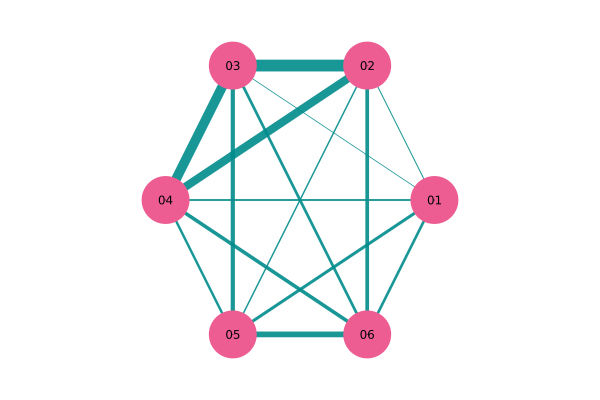

Quasi-optimal ordering: [1, 5, 6, 4, 3, 2]


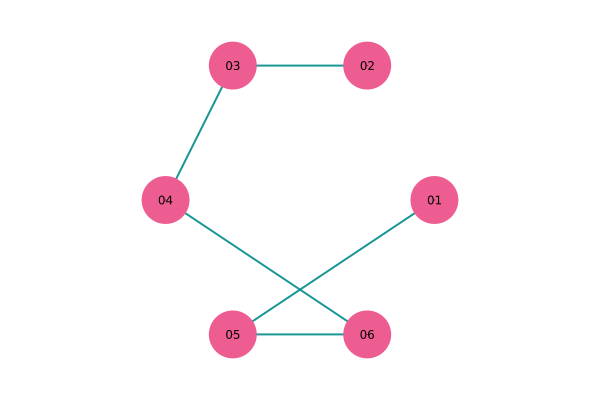

In [4]:
# Visualize the mutual information and calculate a "quasi-optimal" ordering:
fci_array = FCIArray(chemical_data)
fci_mps = MPS(fci_array, siteinds("Electron", chemical_data.N_spt), cutoff=1e-16, maxdim=2^16);

S1, S2, Ipq = MutualInformation(fci_mps, collect(1:chemical_data.N_spt), chemical_data)
OrbitalGraphPlot(Ipq, multiplier=2e1)

gp = GeomParameters(
    maxiter=300000,
    eta=-2,
    shrp=2.0,
    a_alpha=0.8
)

opt_ord = InfDistAnnealing(
    Ipq, 
    1, 
    gp,
    verbose=true
)[1]

println("Quasi-optimal ordering: $(opt_ord)")
OrbitalGraphPlot(GraphMat(opt_ord, directed=false), multiplier=2.0)

In [5]:
# Try a few DMRG calculations with different max. bond dimensions:

maxdims = [4,8,12,16]

#e_dmrg_list = []

"""
for n_x=1:length(bond_lengths)

    println("\n $(bond_lengths[n_x]) Angstrom [$(n_x)/$(length(bond_lengths))]: \n")
    
    fci_array = FCIArray(chemical_data_list[n_x])
    fci_mps = MPS(fci_array, siteinds("Electron", chemical_data_list[n_x].N_spt), cutoff=1e-16, maxdim=2^16);

    S1, S2, Ipq = MutualInformation(fci_mps, collect(1:chemical_data.N_spt), chemical_data_list[n_x])

    opt_ord = InfDistAnnealing(
        Ipq, 
        1, 
        gp,
        verbose=false
    )[1]
"""
    
e_dmrg = []

#psi_dmrg = []

for k=1:4

    dmrg_k = GenSubspace(
        chemical_data_list[n_x], 
        M=1, 
        psi_maxdim=maxdims[k], 
        init_ord = deepcopy(opt_ord),
        dflt_sweeps=Sweeps(
            20, 
            maxdim=maxdims[k], 
            noise=(1e-4,1e-6,1e-8,1e-10)
        ),
        verbose=false
    );

    push!(e_dmrg, dmrg_k.E[1])

    #push!(psi_dmrg, dmrg_k.psi_list[1])

    println("Bond dim. $(maxdims[k]): E_dmrg = $(dmrg_k.E[1]); error = $(abs(dmrg_k.E[1]+chemical_data_list[n_x].e_nuc - chemical_data_list[n_x].e_fci)); params = $(CountNonZeros(dmrg_k.psi_list))")

end
    
    #push!(e_dmrg_list, e_dmrg)
    
#end

Bond dim. 4: E_dmrg = -7.02519157599363; error = 0.1765374393790191; params = 46
Bond dim. 8: E_dmrg = -7.176522206464314; error = 0.02520680890833482; params = 92
Bond dim. 12: E_dmrg = -7.183226450449142; error = 0.01850256492350688; params = 169
Bond dim. 16: E_dmrg = -7.201728979500226; error = 3.587242325409079e-8; params = 272


In [58]:
## Subspace for TNQE calculations:

# Initialize the NOMPS starting ansatz:
M = 3
m = 5

nomps0 = GenSubspace(
    chemical_data, 
    M=M, 
    psi_maxdim=m, 
    ham_tol=1e-12,
    thresh="projection", 
    init_ord = deepcopy(opt_ord),
    eps=1e-12, 
    sweep_num=12, 
    sweep_noise=(1e-2,1e-3,1e-4,1e-5,1e-6),
    dmrg_init=false,
    ovlp_opt=true,
    ovlp_weight=2.0,
    verbose=true
);


Generating Hamiltonian MPO:
Done!


Generating states:

Done!

Minimum eigenvalue: -6.352437227284631
Condition number: 1.1724617671285391
FCI energy: -2.798409558813491
Final energy estimate: -1.949117770725473
Best single ref. estimate: -1.9424905697581698
Error: 0.849291788088018
BSRfE: 0.8559189890553212
Improvement: 0.006627200967303182
Percentage error reduction: 0.7742789974338146
Eigenvalue condition numbers: [0.1558, 0.1635, 0.1606]
Percent correlation energy with single-geometry DMRG: -147.69748161019177
Percent correlation energy with multi-geometry TNQE: -145.7796120329116


In [59]:
CountNonZeros(nomps0.psi_list)

191

In [8]:
#CountNonZeros([psi_dmrg[3]])

LoadError: UndefVarError: psi_dmrg not defined

In [8]:
linkdims(nomps0.ham_list[1])

5-element Vector{Int64}:
 14
 40
 36
 40
 18

In [60]:
# The optimization parameters:
op1 = OptimParameters(
    maxiter=1, 
    numloop=1, 
    noise=[0.0], 
    thresh="projection",
    eps=1e-10,
    sd_thresh="projection", 
    sd_eps=1.0e-10,
    delta=[0.0],
    ttol=10.0,
    theta=0.0,
    sd_method="triple_geneig",
    sd_penalty=0.99999,
    sd_swap_penalty=0.999,
    sd_dtol=5e-3,
    sd_etol=0.001,
    swap_mult=2.0
)

OptimParameters
  maxiter: Int64 1
  numloop: Int64 1
  numopt: Int64 -1
  noise: Array{Float64}((1,)) [0.0]
  delta: Array{Float64}((1,)) [0.0]
  theta: Float64 0.0
  ttol: Float64 10.0
  swap_mult: Float64 2.0
  thresh: String "projection"
  eps: Float64 1.0e-10
  sd_method: String "triple_geneig"
  sd_thresh: String "projection"
  sd_eps: Float64 1.0e-10
  sd_reps: Int64 3
  sd_penalty: Float64 0.99999
  sd_swap_penalty: Float64 0.999
  sd_dtol: Float64 0.005
  sd_etol: Float64 0.001


In [61]:
nomps1 = deepcopy(nomps0)

#tnqe1.mparams.psi_maxdim = 8

SeedNoise!(
    nomps1,
    2.0,
    0.0,
    penalty=0.0
)

for k=1:16
    
    #ShuffleStates!(nomps1)
    
    SeedNoise!(
        nomps1,
        0.0,
        0.01,
        penalty=0.0
    )
    
    ReverseAll!(nomps1)
    
    TwoSiteBlockSweep!(
        nomps1,
        op1,
        verbose=true,
        nsite=[2 for i=1:nomps1.mparams.M],
        no_swap=true,
        no_rev=true
    )
    
    TwoSiteBlockSweep!(
        nomps1,
        op1,
        verbose=true,
        nsite=[1 for i=1:nomps1.mparams.M],
        no_swap=true,
        no_rev=true
    )
    
end

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.05981; Delta = 0.14192; kappa_full = 5080.0; kappa = 542.0      
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.0629; Delta = 0.13883; kappa_full = 4370.0; kappa = 291.0       
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.1382; Delta = 0.06353; kappa_full = 42.7; kappa = 8.57        
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.15232; Delta = 0.04941; kappa_full = 106.0; kappa = 3.02      
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.17882; Delta = 0.0229; kappa_full = 15.2; kappa = 1.03       
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.1799; Delta = 0.02183; kappa_full = 12.9; kappa = 1.18      
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.18089; Delta = 0.02084; kappa_full = 8.85; kappa = 1.08       
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.18415; Delta = 0.01758; kappa_full = 104.0; kappa = 1.6      
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.18743; Delta = 0.0143; kap

In [64]:
tnqe1 = deepcopy(nomps1)

#tnqe1.mparams.psi_maxdim = 8

tnqe1_deltavec = []

for k=1:16
    
    ShuffleStates!(tnqe1)

    SeedNoise!(
        tnqe1,
        0.01,
        0.0,
        penalty=0.0
    )
    
    #ReverseAll!(tnqe1)
    
    TwoSiteBlockSweep!(
        tnqe1,
        op1,
        verbose=true,
        nsite=[2 for i=1:tnqe1.mparams.M],
        no_swap=false,
        no_rev=true
    )
    
    TwoSiteBlockSweep!(
        tnqe1,
        op1,
        verbose=true,
        nsite=[1 for i=1:tnqe1.mparams.M],
        no_swap=false,
        no_rev=true
    )
    
    push!(tnqe1_deltavec, tnqe1.E[1]+tnqe1.chem_data.e_nuc-tnqe1.chem_data.e_fci)
    
end

Loop: (1/1); Bond: 5/5; #swaps: 4; E_min = -7.18865; Delta = 0.01308; kappa_full = 186.0; kappa = 1.52     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.18869; Delta = 0.01304; kappa_full = 168.0; kappa = 1.52     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 4; E_min = -7.19056; Delta = 0.01117; kappa_full = 170.0; kappa = 1.06     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.19292; Delta = 0.00881; kappa_full = 154.0; kappa = 1.3     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.19444; Delta = 0.00729; kappa_full = 56.9; kappa = 2.69        
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.1974; Delta = 0.00433; kappa_full = 58.8; kappa = 2.82      
Done!

Loop: (1/1); Bond: 5/5; #swaps: 1; E_min = -7.19732; Delta = 0.00441; kappa_full = 52.6; kappa = 3.33       
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.19839; Delta = 0.00334; kappa_full = 59.6; kappa = 3.31     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 1; E_min = -7.19841; Delta = 0.00332; kappa_full

In [65]:
tnqe2 = deepcopy(nomps1)

#tnqe1.mparams.psi_maxdim = 8

tnqe2_deltavec = []

for k=1:16
    
    #ShuffleStates!(tnqe1)
    
    SeedNoise!(
        tnqe2,
        0.01,
        0.0,
        penalty=0.0
    )
    
    ReverseAll!(tnqe2)
    
    TwoSiteBlockSweep!(
        tnqe2,
        op1,
        verbose=true,
        nsite=[2 for i=1:tnqe2.mparams.M],
        no_swap=true,
        no_rev=true
    )
    
    TwoSiteBlockSweep!(
        tnqe2,
        op1,
        verbose=true,
        nsite=[1 for i=1:tnqe2.mparams.M],
        no_swap=true,
        no_rev=true
    )
    
    push!(tnqe2_deltavec, tnqe2.E[1]+tnqe2.chem_data.e_nuc-tnqe2.chem_data.e_fci)
    
end

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.18868; Delta = 0.01305; kappa_full = 2.89; kappa = 1.51      
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.18869; Delta = 0.01304; kappa_full = 1.77; kappa = 1.54      
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.18865; Delta = 0.01308; kappa_full = 139.0; kappa = 1.57     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.18869; Delta = 0.01304; kappa_full = 159.0; kappa = 1.57     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.18829; Delta = 0.01344; kappa_full = 1.81; kappa = 1.6       
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.18869; Delta = 0.01304; kappa_full = 1.86; kappa = 1.59      
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.18863; Delta = 0.0131; kappa_full = 167.0; kappa = 1.89     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.18869; Delta = 0.01304; kappa_full = 176.0; kappa = 1.91     
Done!

Loop: (1/1); Bond: 5/5; #swaps: 0; E_min = -7.18868; Delta = 0.01305; kappa_full 

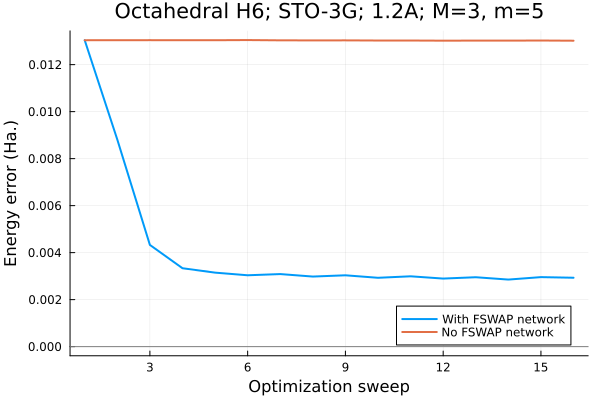

In [67]:
plt1 = plot(1:16, tnqe1_deltavec, lw=2.0, label="With FSWAP network", xlabel="Optimization sweep", ylabel="Energy error (Ha.)", title="Octahedral H6; STO-3G; 1.2A; M=3, m=5")
plot!(1:16, tnqe2_deltavec, lw=2.0, label="No FSWAP network")
hline!([0.0], color=RGB(0.5,0.5,0.5), primary=false)

In [300]:
PrintFSWAPNetworks!(tnqe1)



###### 1-2 ######

1---x-5
    |  
6-x-x-1
  |    
5-x---6
       
2-x---3
  |    
3-x---2
       
4-----4


###### 1-3 ######

1---x-5
    |  
6-x-x-1
  |    
5-x---6
       
2-x---3
  |    
3-x---2
       
4-----4


###### 1-4 ######

1---1
     
6-x-5
  |  
5-x-6
     
2-x-3
  |  
3-x-2
     
4---4


###### 2-3 ######

5-5
   
1-1
   
6-6
   
3-3
   
2-2
   
4-4


###### 2-4 ######

5-x-1
  |  
1-x-5
     
6---6
     
3---3
     
2---2
     
4---4


###### 3-4 ######

5-x-1
  |  
1-x-5
     
6---6
     
3---3
     
2---2
     
4---4


In [258]:
GenPermOps!(tnqe1);
GenHams!(tnqe1)
GenSubspaceMats!(tnqe1)
SolveGenEig!(tnqe1)
DisplayEvalData(tnqe1)

Minimum eigenvalue: -7.198503502836015
Condition number: 3.0530453467468077
FCI energy: -2.798409558813491
Final energy estimate: -2.795184046276857
Best single ref. estimate: -2.5657187654132985
Error: 0.0032255125366340565
BSRfE: 0.2326907934001925
Improvement: 0.22946528086355844
Percentage error reduction: 98.6138203022555
Eigenvalue condition numbers: [0.1711, 0.1243, 0.1552, 0.2537]
Percent correlation energy with single-geometry DMRG: 32.660772507548806
Percent correlation energy with multi-geometry TNQE: 99.06655729988167


In [259]:
println(tnqe1.C[:,1])

[0.21338688508571185, 0.49526922547643165, 0.9272216123481132, 0.3044039422766631]


In [260]:
tnqe_to_dmrg = SumMPS(tnqe1, final_ord=opt_ord, cutoff=1e-12);
truncate!(tnqe_to_dmrg, cutoff=1e-5)
println(inner(tnqe_to_dmrg', nomps0.ham_list[1], tnqe_to_dmrg) + chemical_data.e_nuc - chemical_data.e_fci)
linkdims(tnqe_to_dmrg)

0.0033062914153063616


5-element Vector{Int64}:
  4
 12
 13
 16
  4

In [261]:
nomps_to_dmrg = SumMPS(nomps1, final_ord=opt_ord, cutoff=1e-12);
truncate!(nomps_to_dmrg, cutoff=1e-5)
println(inner(nomps_to_dmrg', nomps0.ham_list[1], nomps_to_dmrg) + chemical_data.e_nuc - chemical_data.e_fci)
linkdims(nomps_to_dmrg)

0.019772768655159645


5-element Vector{Int64}:
  4
 10
 13
 15
  4

In [49]:


for k=1:20
    
    ShuffleStates!(tnqe1)
    
    SeedNoise!(
        tnqe1,
        0.0005,
        0.0,
        penalty=0.999
    )
    
    ReverseAll!(tnqe1)
    
    TwoSiteBlockSweep!(
        tnqe1,
        op1,
        verbose=true,
        n_twos=2,
        no_swap=true,
        debug_output=true
    )
end

LoadError: MPO A and MPS B must share site indices. On site 2, A has site indices Index{Vector{Pair{QN, Int64}}}[(dim=4|id=408|"Electron,Site,n=2")' <Out>
 1: QN(("Nf",0,-1),("Sz",0)) => 1
 2: QN(("Nf",1,-1),("Sz",1)) => 1
 3: QN(("Nf",1,-1),("Sz",-1)) => 1
 4: QN(("Nf",2,-1),("Sz",0)) => 1, (dim=4|id=408|"Electron,Site,n=2") <In>
 1: QN(("Nf",0,-1),("Sz",0)) => 1
 2: QN(("Nf",1,-1),("Sz",1)) => 1
 3: QN(("Nf",1,-1),("Sz",-1)) => 1
 4: QN(("Nf",2,-1),("Sz",0)) => 1] while B has site indices Index{Vector{Pair{QN, Int64}}}[].

In [10]:
for k=1:10
    
    ShuffleStates!(tnqe1)
    
    SeedNoise!(
        tnqe1,
        0.001,
        0.0,
        penalty=0.999
    )
    
    ReverseAll!(tnqe1)
    
    TwoSiteBlockSweep!(
        tnqe1,
        op1,
        verbose=true,
        n_twos=2,
        no_swap=false,
        debug_output=true
    )
end

Loop: (1/1); Bond: 5/5; #swaps: 2; E_min = -8.32577; Delta = 0.00716; kappa_full = 1.74; kappa = 1.51      
Done!



LoadError: InterruptException:

In [92]:
println([maxlinkdim(tnqe1.perm_ops[j]) for j=1:tnqe1.mparams.M])

[16, 16, 16, 16]


In [97]:
PrintFSWAPNetwork(tnqe1.ord_list[1], tnqe1.ham_ord)

3---x-2
    |  
4-x-x-3
  |    
2-x---4
       
6-x---5
  |    
5-x---6
       
1-----1


In [83]:
e_dmrg_set = []
for k=1:4
    push!(e_dmrg_set, [e_dmrg_list[n_x][k]+chemical_data_list[n_x].e_nuc for n_x=1:length(bond_lengths)])
end
#+chemical_data_list[n_x].e_nuc
e_fci = [chemical_data_list[n_x].e_fci for n_x=1:length(bond_lengths)]
e_rhf = [chemical_data_list[n_x].e_rhf for n_x=1:length(bond_lengths)];

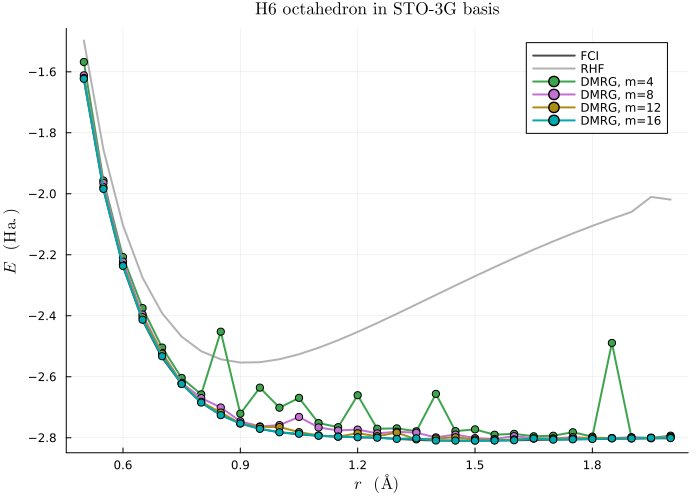

In [86]:
using LaTeXStrings

n_s, n_f = 1, 31

plt1 = plot(
    bond_lengths[n_s:n_f], 
    e_fci[n_s:n_f], 
    color=RGB(0.3,0.3,0.3),
    linewidth=2.0,
    label="FCI",
    title="H6 octahedron in STO-3G basis",
    titlefontsize=11.0,
    titlefont=font(14,"Computer Modern"),
    xguide=L"r\quad(\AA)",
    yguide=L"E\quad(\textrm{Ha.})",
    size=(700,500)
)

plot!(
    bond_lengths[n_s:n_f], 
    e_rhf[n_s:n_f], 
    color=RGB(0.7,0.7,0.7), 
    linewidth=2.0,
    label="RHF"
)

for k=1:4

    plot!(
        bond_lengths[n_s:n_f], 
        e_dmrg_set[k][n_s:n_f], 
        #color=color=RGB(1.0,0.8,0.3), 
        linewidth=2.0,
        markersize=4,
        markershape=:circle,
        label="DMRG, m=$(maxdims[k])"
    )
end

display(plt1)

In [7]:
[0,1] .+ rand(1:5)

2-element Vector{Int64}:
 1
 2

In [3]:
Int(false)*2

0

In [263]:
vec = [1,1,2,2,1,1]


6-element Vector{Int64}:
 1
 1
 2
 2
 1
 1

In [266]:
sum(vec .== 2)

2

In [66]:
0.01*randn()

-0.006496926978253544